# Reminder

Try me out interactively with: [![Binder](./img/badge_logo.svg)](https://mybinder.org/v2/gh/rte-france/Grid2Op/master)

## Goals
- Keep the grid safe
- Avoid blackouts
- Cost efficiency 

# Live Demo 1: How to perform actions

## 3 types of actions:
    
- Changing the status of a powerline
- Changing the topology of a substation
- Changing the setpoint of generator

## 0) Import the environment

In [1]:
import grid2op
import numpy as np # recommended
env = grid2op.make("l2rpn_neurips_2020_track1", test=True)  # i do a test, i set "Test=True" otherwise i don't specify anything
max_iter = 5  # we limit the number of iterations to reduce computation time. Put -1 if you don't want to limit it
env.seed(42)
obs = env.reset()

/home/benjamin/Documents/grid2op_dev/getting_started/grid2op/MakeEnv/Make.py:305: UserWarning: You are using a development environment. This environment is not intended for training agents. It might not be up to date and its primary use if for tests (hence the "test=True" you passed as argument). Use at your own risk.
  warnings.warn(_MAKE_DEV_ENV_WARN)


And with just that, we are ready to go!

## 1) Overall information about the environment

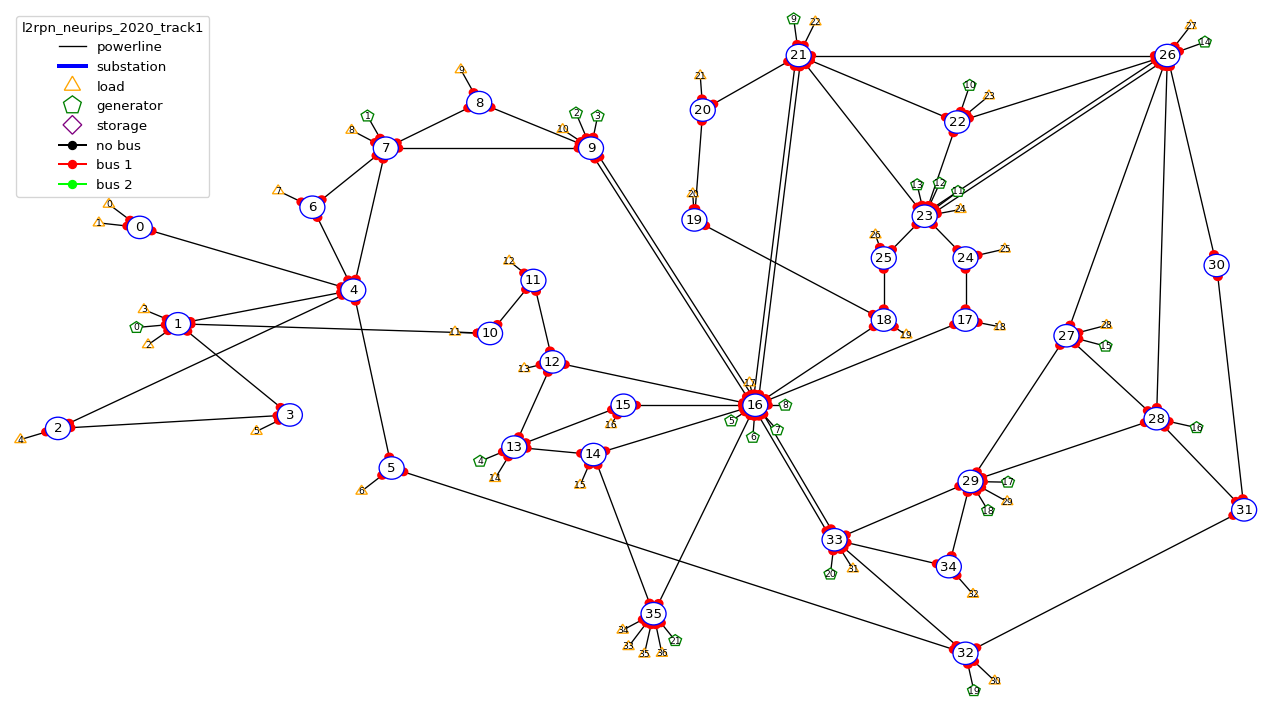

In [2]:
# %matplotlib inline
from grid2op.PlotGrid import PlotMatplot
plot_helper = PlotMatplot(env.observation_space)

_ = plot_helper.plot_layout()

We can also plot the actual state of the grid visible by the agent, also called "observation"

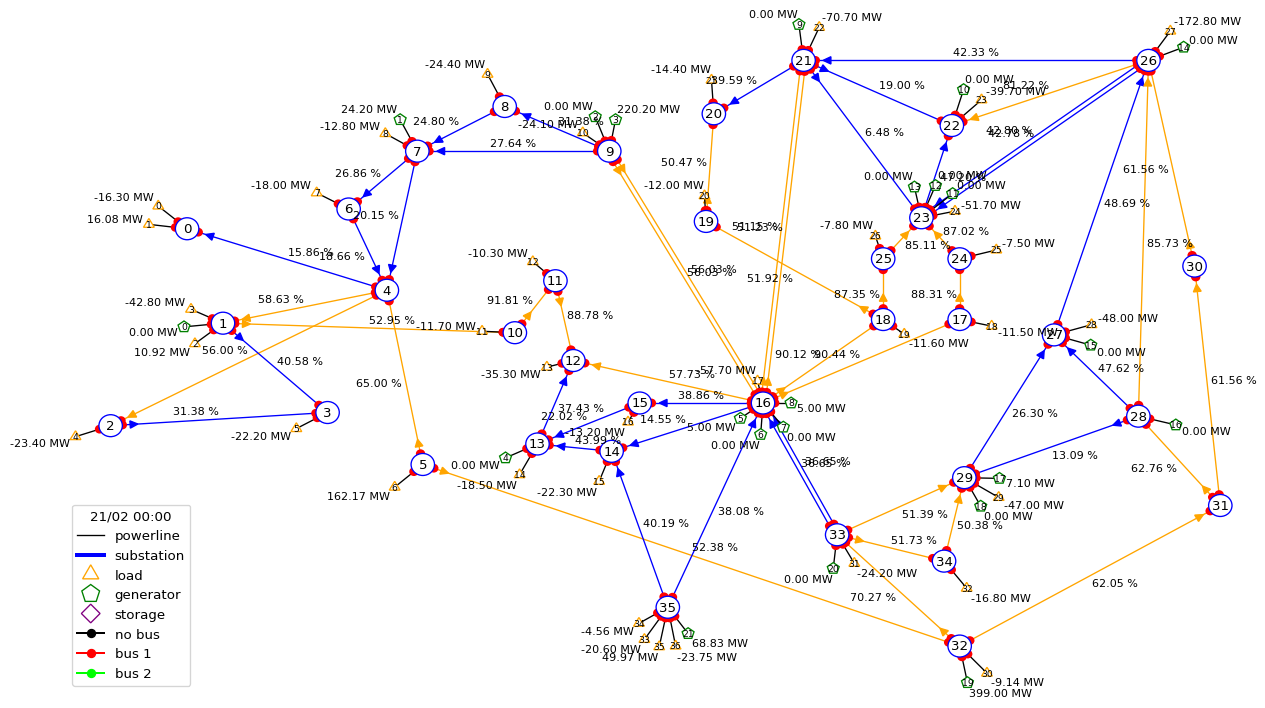

In [3]:
_ = plot_helper.plot_obs(obs)

## 2) Change the status of the powerline
The first type of action is the switching on / off of powerline.

This is rather easy to do in grid2op :-)

**cost of the action**: 0

**cooldown**: 3 time steps (for the affected lines)

**maximum**: maximum 1 powerline affected per action

This action will:
	 - NOT change anything to the injections
	 - NOT perform any redispatching action
	 - NOT modify any storage capacity
	 - NOT perform any curtailment
	 - Force disconnection of 1 powerlines ([3])
	 - NOT switch any line status
	 - NOT switch anything in the topology
	 - NOT force any particular bus configuration


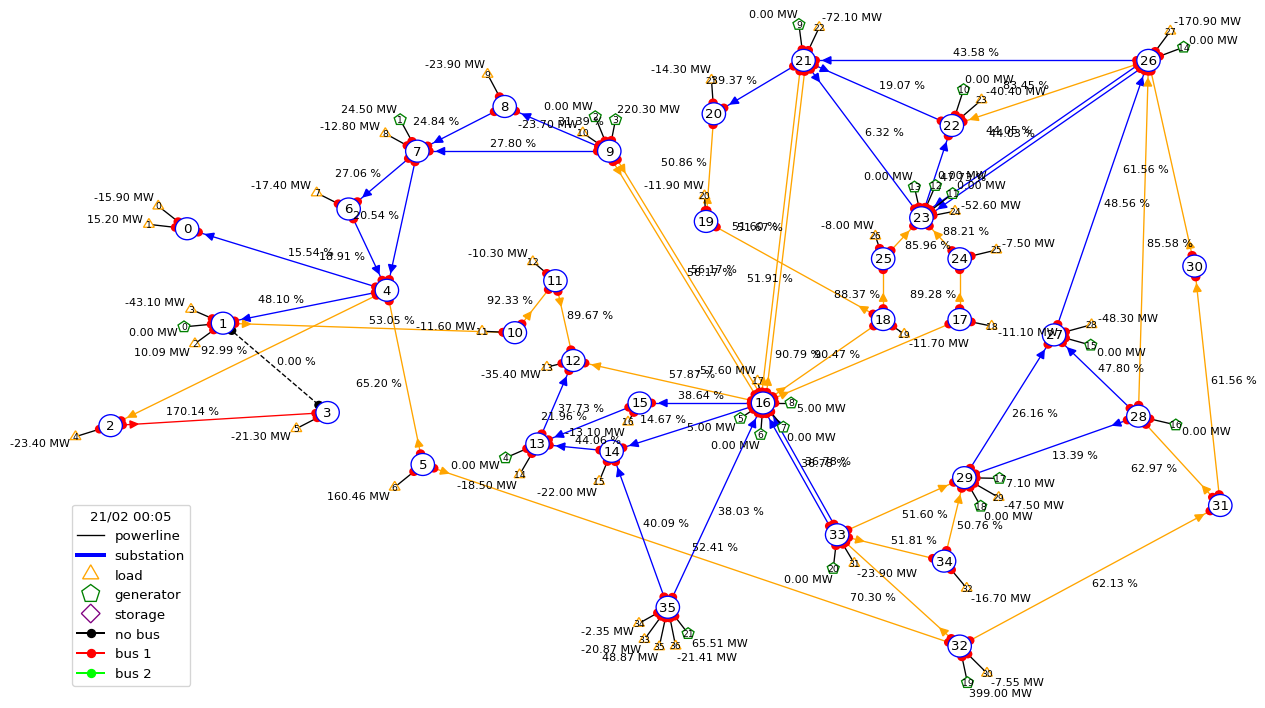

In [4]:
l_id = 3
disconnect_line_3 = env.action_space({"set_line_status": [(l_id, -1)]})
print(disconnect_line_3)
next_obs, reward, done, extra_information = env.step(disconnect_line_3)
_ = plot_helper.plot_obs(next_obs)

In [5]:
print("I need to wait {} timesteps before using this line again".format(next_obs.time_before_cooldown_line[l_id]))
print("Be carefull, powerline 0 is in overflow for {} timestep".format(next_obs.timestep_overflow[0]))

I need to wait 3 timesteps before using this line again
Be carefull, powerline 0 is in overflow for 1 timestep


And now let's try to connect the powerline.

This action will:
	 - NOT change anything to the injections
	 - NOT perform any redispatching action
	 - NOT modify any storage capacity
	 - NOT perform any curtailment
	 - Force reconnection of 1 powerlines ([3])
	 - NOT switch any line status
	 - NOT switch anything in the topology
	 - NOT force any particular bus configuration
Was this action illegal? True
I need to wait 2 timesteps before using this line again
Be carefull, powerline 0 is in overflow for 2 timestep


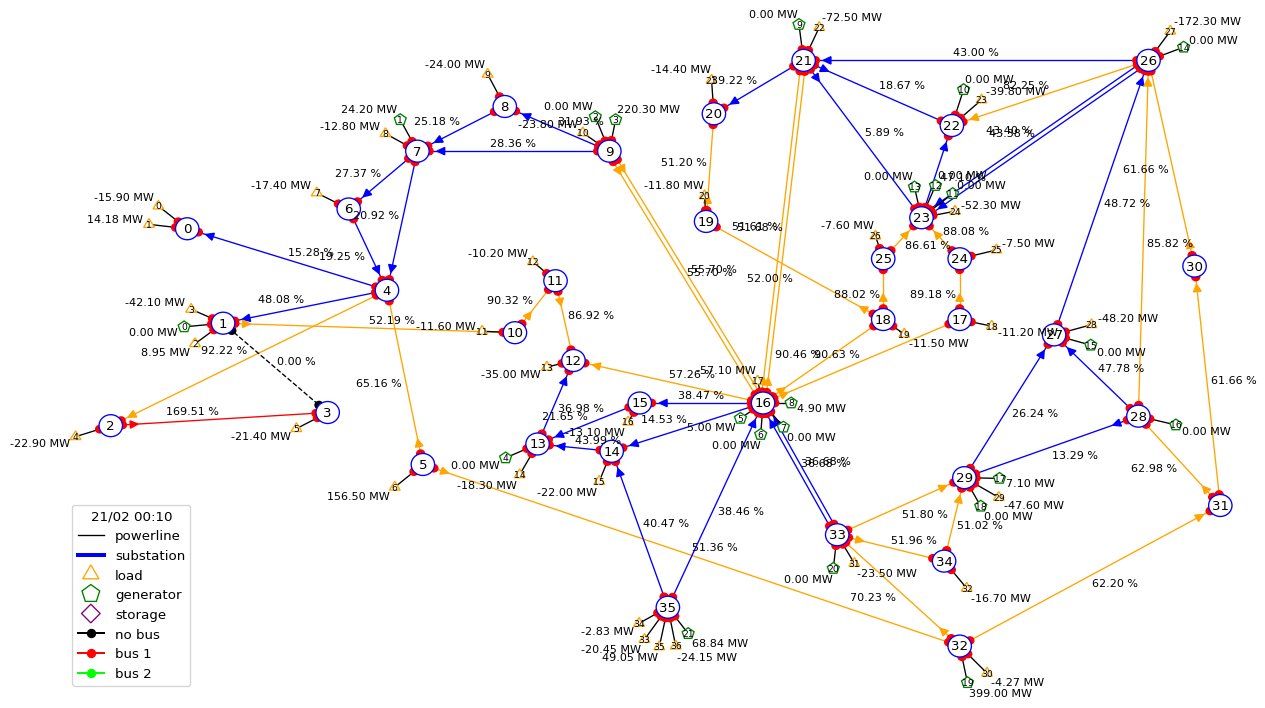

In [6]:
reconnect_line_3 = env.action_space({"set_line_status": [(l_id, +1)]})
print(reconnect_line_3)
next_obs1, reward1, done1, extra_information1 = env.step(reconnect_line_3)
_ = plot_helper.plot_obs(next_obs1)
print("Was this action illegal? {}".format(extra_information1["is_illegal"]))
print("I need to wait {} timesteps before using this line again".format(next_obs1.time_before_cooldown_line[l_id]))
print("Be carefull, powerline 0 is in overflow for {} timestep".format(next_obs1.timestep_overflow[0]))

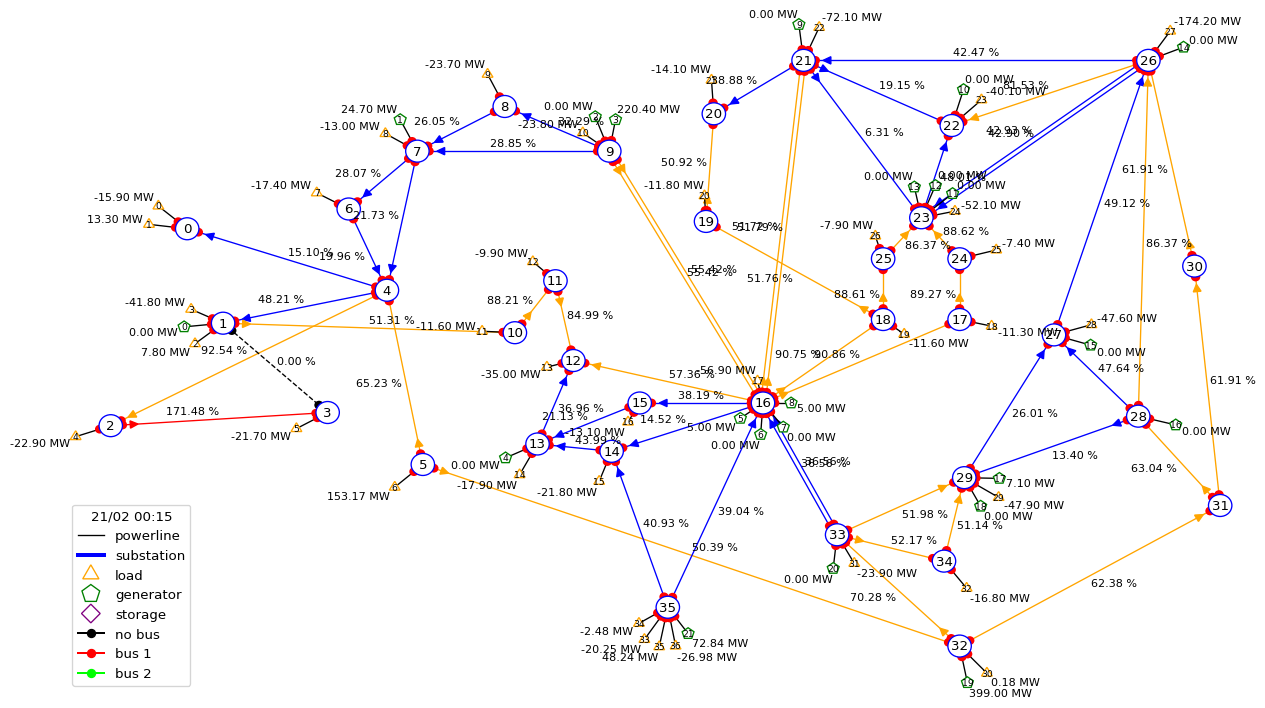

In [7]:
do_nothing = env.action_space()
next_obs2, reward2, done2, extra_information2 = env.step(do_nothing)
_ = plot_helper.plot_obs(next_obs2)

Is the game over? True


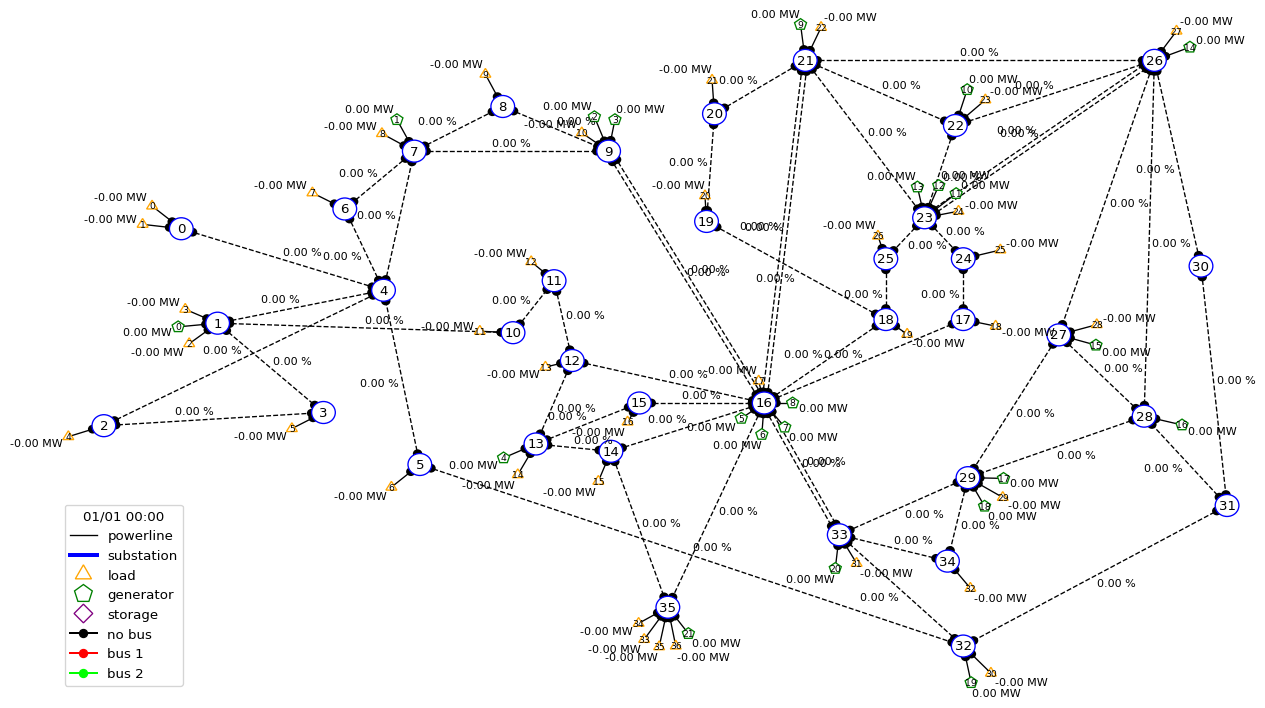

In [8]:
next_obs3, reward3, done3, extra_information3 = env.step(do_nothing)
print("Is the game over? {}".format(done3))
# plot the "last" observation
next_obs3.line_status[extra_information3["disc_lines"]] = False
_ = plot_helper.plot_obs(next_obs3)

You can affect the status of a powerline with:

| action      | original status | final status |
|-------------|-----------------|--------------|
| {"set_line_status": [(l_id, -1)]}             | Connected | **Dis**connected |
| {"set_line_status": [(l_id, +1)]}             | Connected | Connected |
| {"set_line_status": [(l_id, -1)]}             | **Dis**connected | **Dis**connected |
| {"set_line_status": [(l_id, +1)]}             | **Dis**connected | Connected |
| {"change_line_status": [l_id]}                | Connected | **Dis**connected |
| {"change_line_status": [l_id]}                | **Dis**connected | Connected |

## 3) Change the topology of a given substation

How is it possible?

![](./img/powergrid_zoom2.png)

![](./img/powergrid_zoom3.png)

All topologies if a substation counts 4 elements:
    
![](./img/all_topo.png)

Changing the topology

**cost of the action**: 0

**cooldown**: 3 time steps (for the affected substation)

**maximum**: 1 substation affected per action (regardless of the element changed)

### How hard is this "topology" problem ?

How many possible actions?

How manypossible topologies?

### And in grid2op?

Topology can also, in some cases save the situation **for free** (just changing some switches) here is an example.

Let's imagine for some reason the powerline from **26** to **27** is disconnected, for example a light storm hit it. Suppose, for the sake of the example that this powerline will be out of order for a few days, meaning you cannot reconnect it.

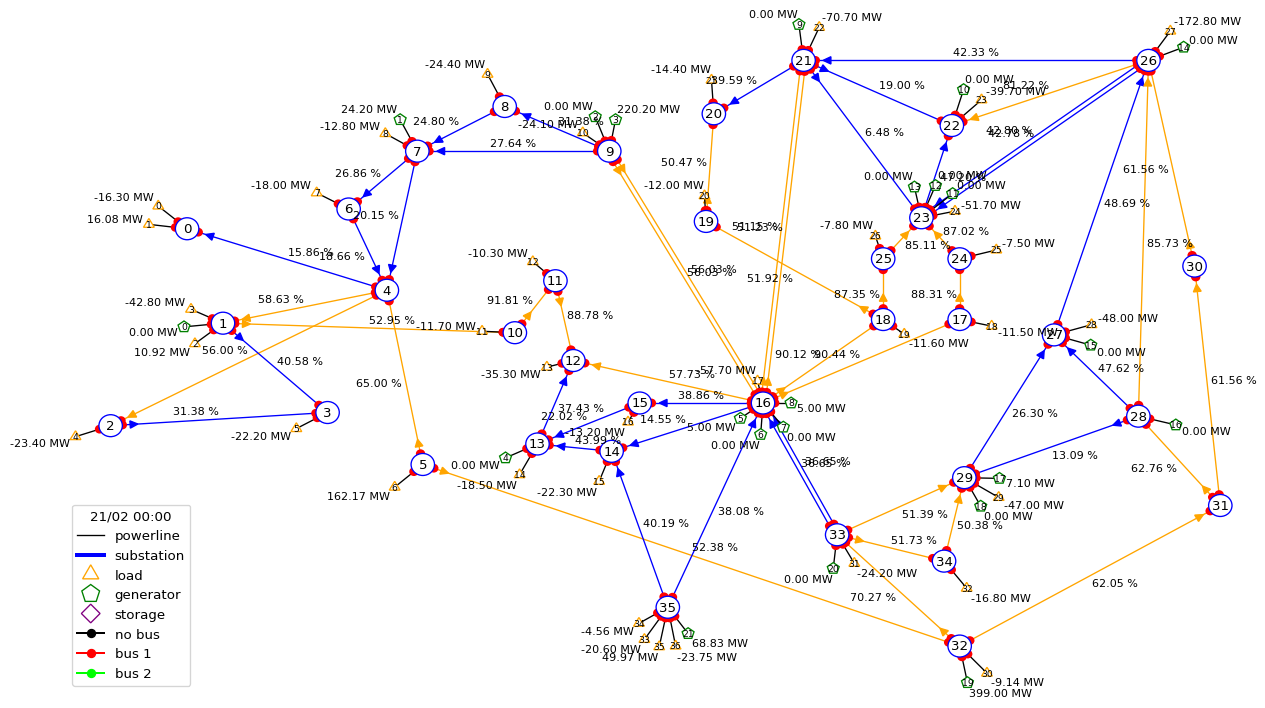

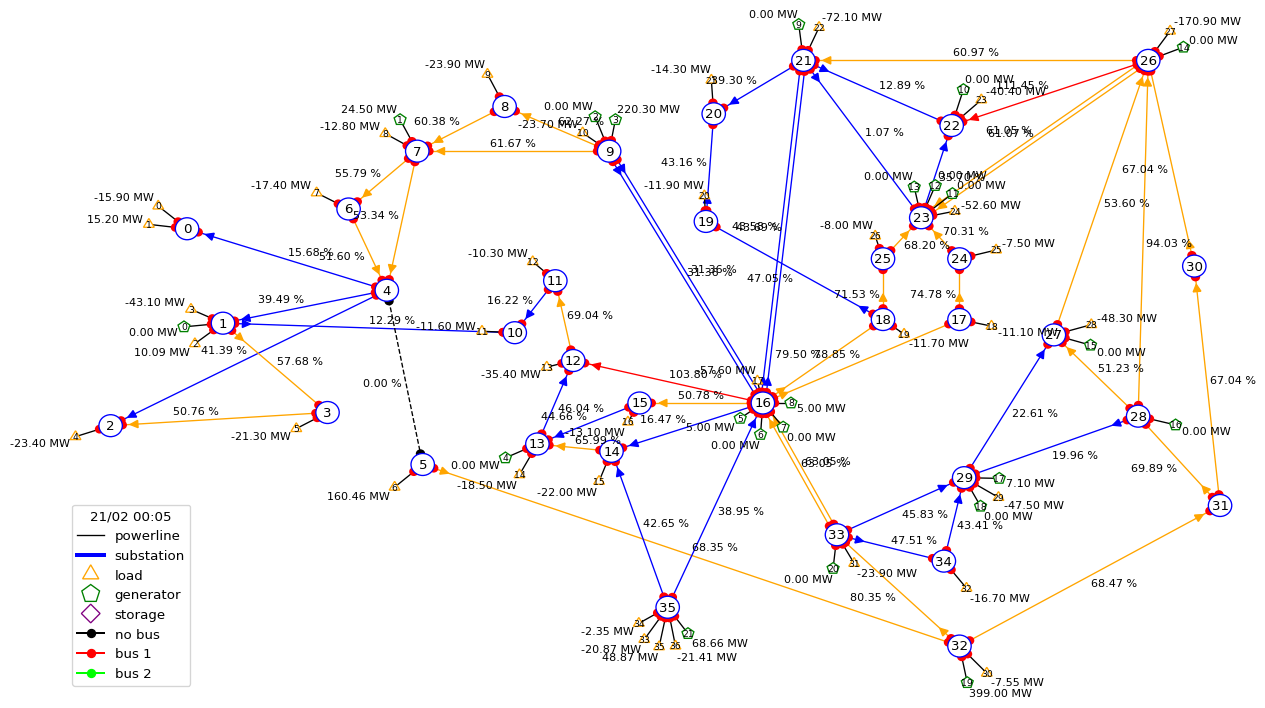

In [9]:
env.set_id(1)
env.seed(1)
obs = env.reset()  # remember we broke everything in our previous demonstration, so we restart properly
_ = plot_helper.plot_obs(obs)
contingency_id = 55
next_obs, reward, done, extra_information = env.step(env.action_space({"set_line_status": 
                                                                       [(contingency_id, -1)]}))
# imagine we are in this state
_ = plot_helper.plot_obs(next_obs)

This does not look great at all, let's see what happen if we don't do anything.

If i don't do anything i could survive 6 time steps :-(


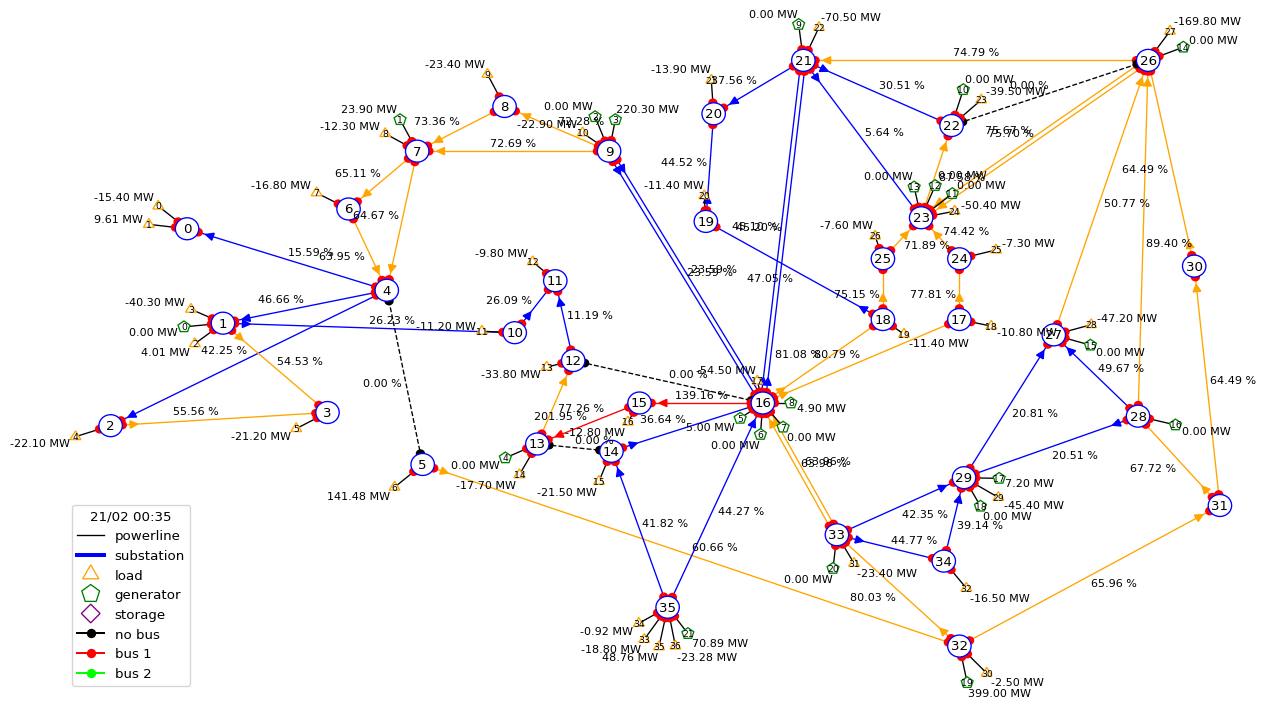

In [10]:
ts_lived = 0
num_step = 0
while not done:
    next_obs, reward, done, extra_information = env.step(do_nothing)
    ts_lived += 1
    num_step += 1
    if max_iter != -1 and num_step > max_iter:
        break
print("If i don't do anything i could survive {} time steps :-(".format(ts_lived))
next_obs.line_status[extra_information["disc_lines"]] = False
_ = plot_helper.plot_obs(next_obs)

Let's replay to demonstrate the proper topological action can solve the issue

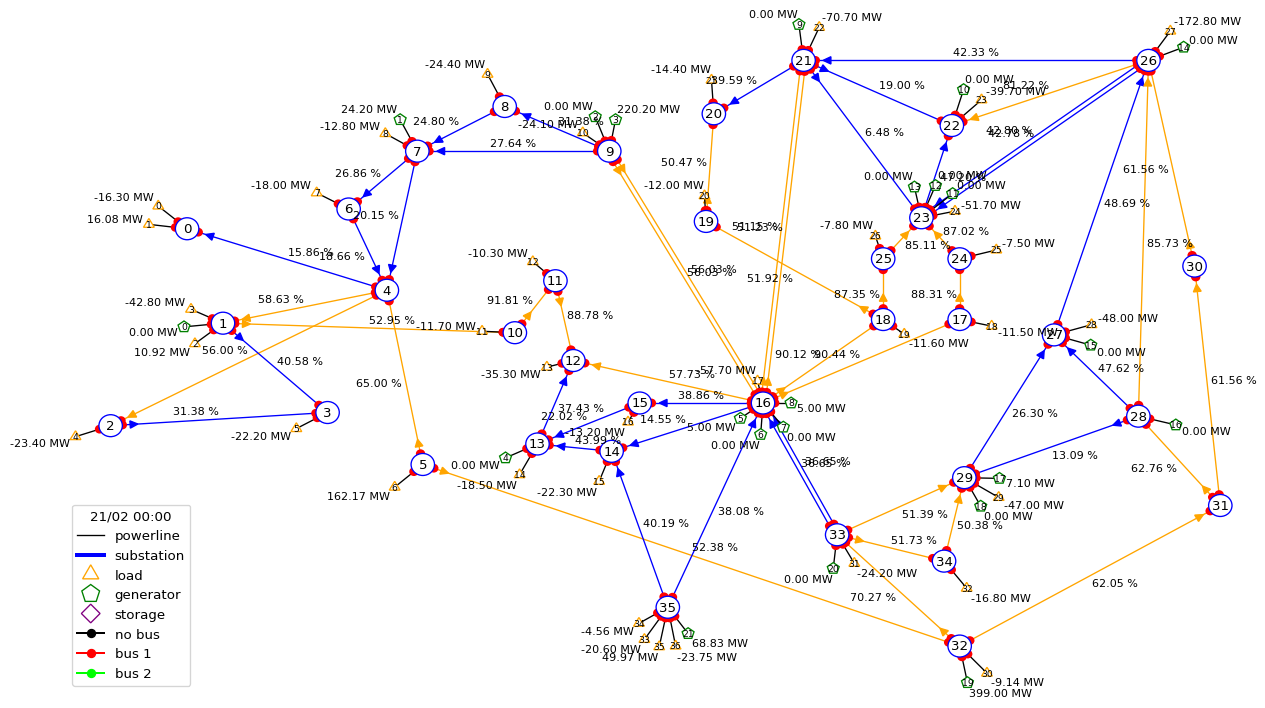

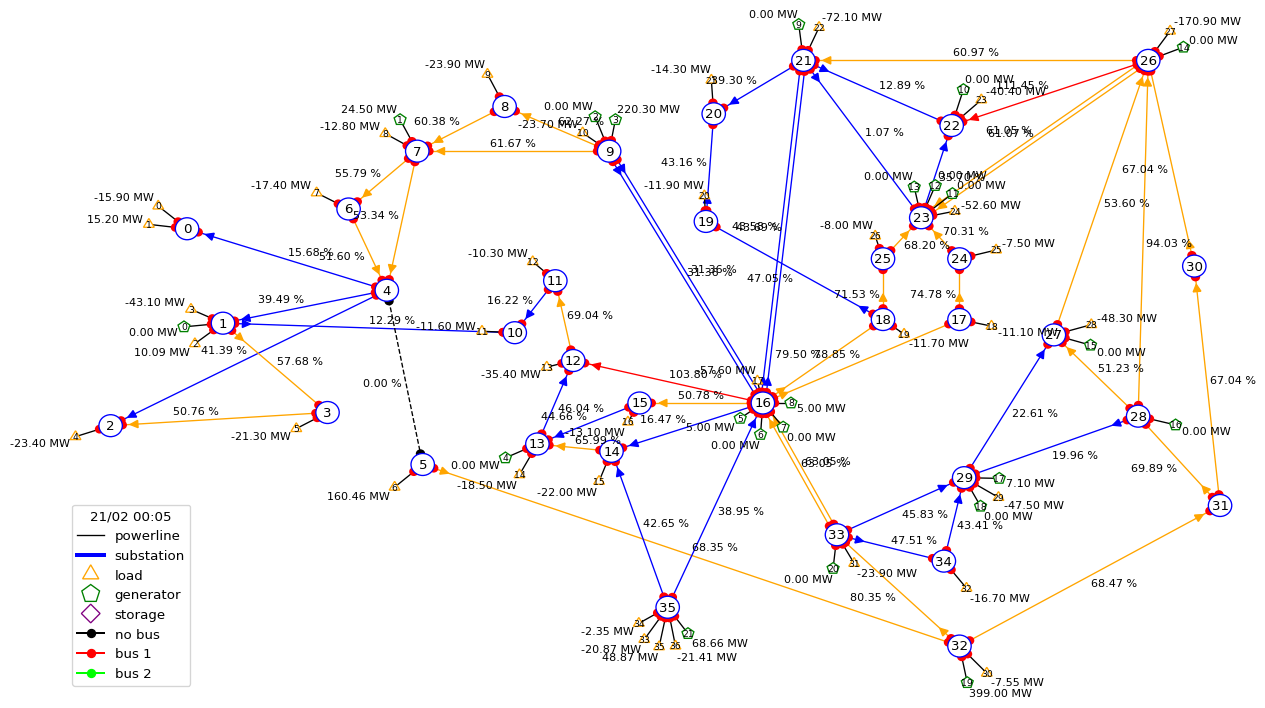

In [11]:
env.set_id(1)
env.seed(1)
obs = env.reset()  # remember we broke everything in our previous demonstration
_ = plot_helper.plot_obs(obs)
next_obs, reward, done, extra_information = env.step(env.action_space({"set_line_status": 
                                                                       [(contingency_id, -1)]}))
# imagine we are in this state
_ = plot_helper.plot_obs(next_obs)

Let's implement the "magic" action now and see what happens.

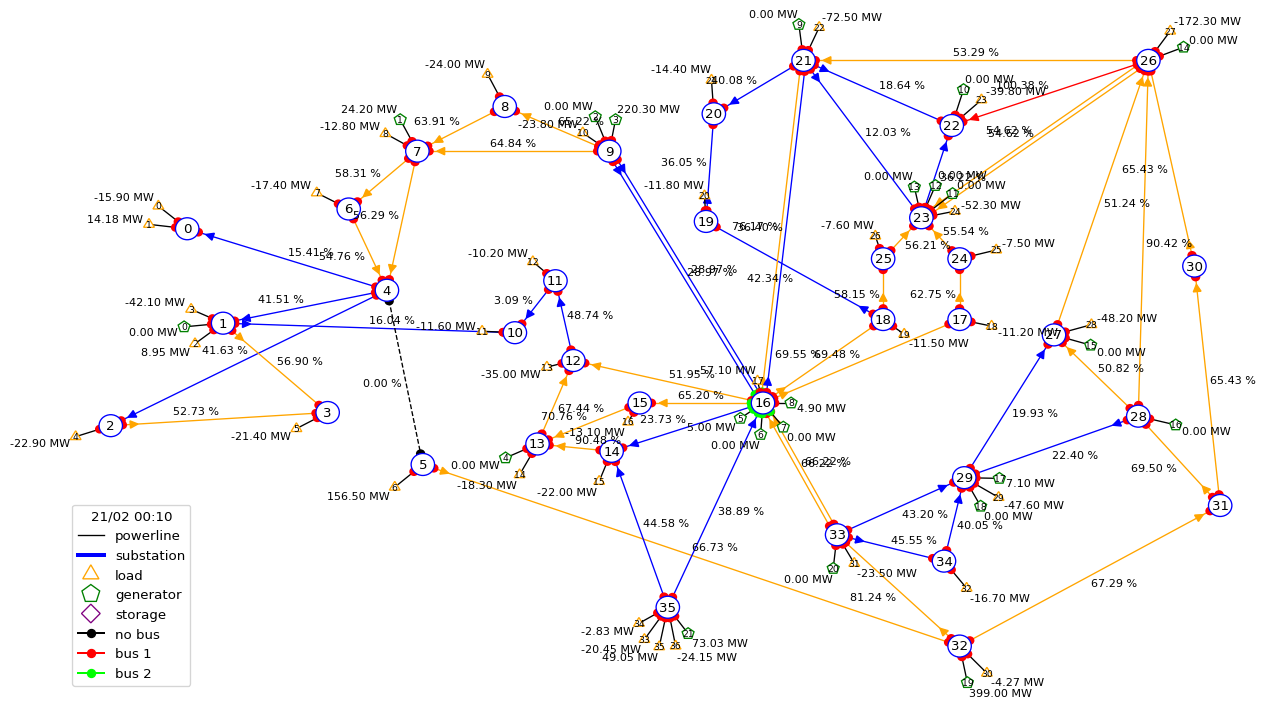

In [12]:
action_saved = env.action_space({"set_bus": {'loads_id': [(17, 1)],  # i want to set to busbar 1 the load of id 27
                                   'generators_id': [(5, 2), (6, 2), (7, 2), (8, 1)],  # busbar 1 for the generator of id 14
                                   'lines_or_id': [(22, 1), (23, 1), (27, 2), (28, 1), (48, 1), (49, 1), (54, 2)],
                                   'lines_ex_id': [(17, 2), (18, 2), (19, 2), (20, 1), (21, 2)]}})
next_obs, reward, done, extra_information = env.step(action_saved)
# imagine we are in this state
_ = plot_helper.plot_obs(next_obs)

If i do the action above i can survive 5 time steps (we stopped the 'game' after 5 time steps)


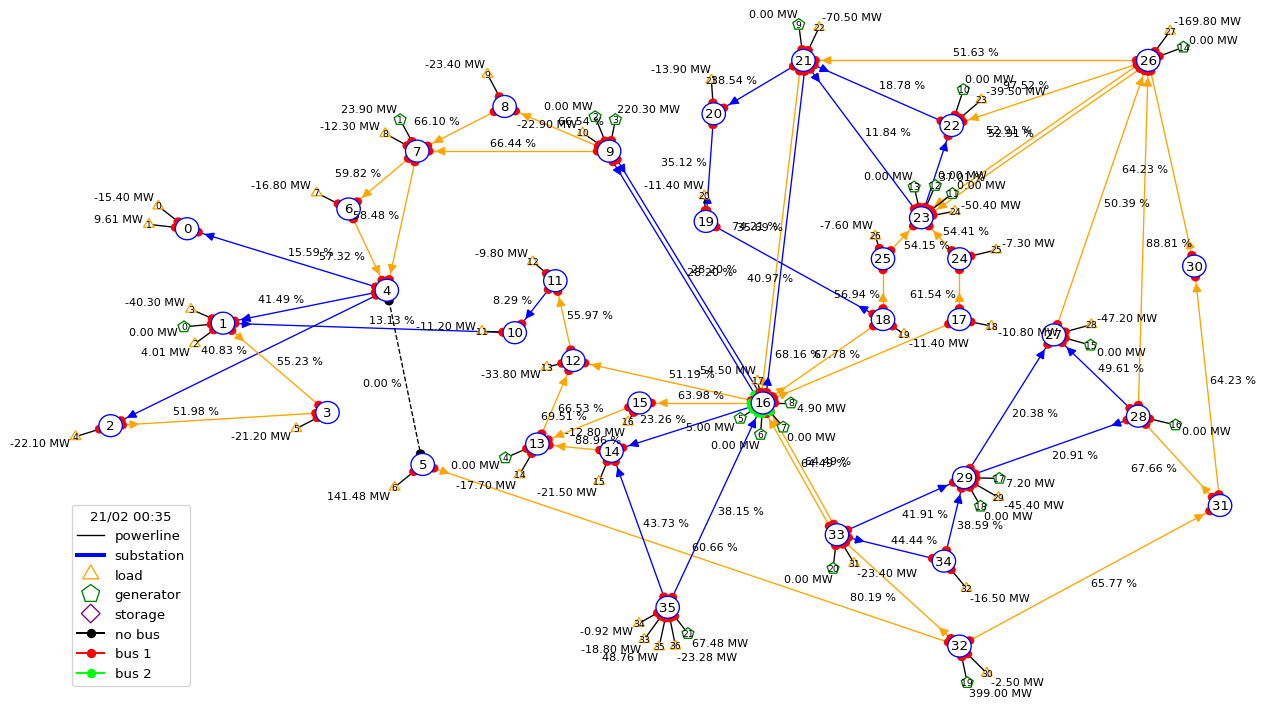

In [13]:
ts_lived_now = 0
while not done:
    next_obs, reward, done, extra_information = env.step(do_nothing)
    ts_lived_now += 1
    if max_iter != -1 and ts_lived_now >= max_iter:
        break
print("If i do the action above i can survive {} time steps (we stopped the 'game' after {} time steps)"
      "".format(ts_lived_now, max_iter))
next_obs.line_status[extra_information["disc_lines"]] = False
_ = plot_helper.plot_obs(next_obs)

Instead of dying after 9 time steps if we do nothing, for the same cost (zero) we can survive at least an extra 51 time steps (comptuation is stopped here because afterwards exogeneous factors appear and it would require other actions, which is beyond the scope of this demonstration).
       
Be carefull at not doing something a bit "risky" though... For example, taking a "random" action at a substation can lead to dramatic effects all over the grid.

The elements connected to the substation 26 are: {'loads_id': array([27]), 'generators_id': array([14]), 'lines_or_id': array([40, 41]), 'lines_ex_id': array([36, 37, 38, 39, 56]), 'storages_id': array([], dtype=int64), 'nb_elements': 9}
This action will:
	 - NOT change anything to the injections
	 - NOT perform any redispatching action
	 - NOT modify any storage capacity
	 - NOT perform any curtailment
	 - NOT force any line status
	 - NOT switch any line status
	 - NOT switch anything in the topology
	 - Set the bus of the following element(s):
	 	 - Assign bus 1 to line (extremity) id 36 [on substation 26]
	 	 - Assign bus 2 to line (extremity) id 37 [on substation 26]
	 	 - Assign bus 1 to line (extremity) id 38 [on substation 26]
	 	 - Assign bus 1 to line (extremity) id 39 [on substation 26]
	 	 - Assign bus 1 to line (origin) id 40 [on substation 26]
	 	 - Assign bus 2 to line (origin) id 41 [on substation 26]
	 	 - Assign bus 2 to line (extremity) id 56 [on substation 26]
	 	 -

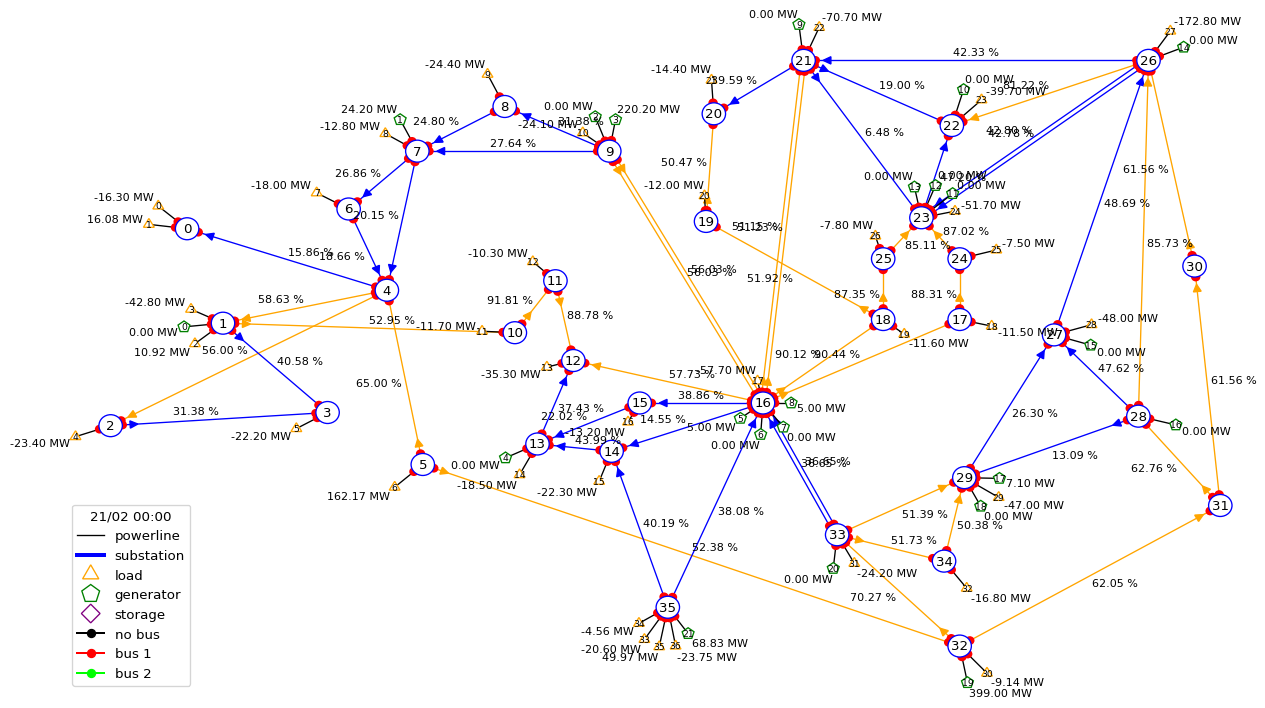

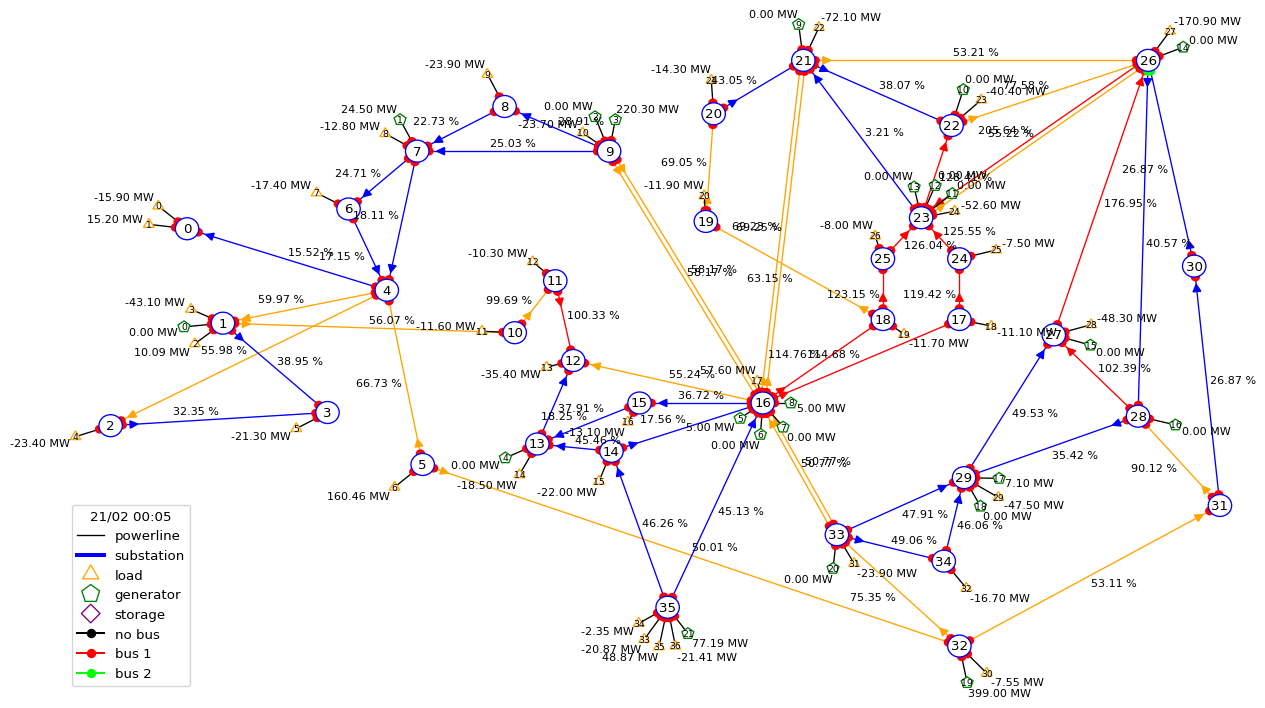

In [14]:
env.set_id(1)  # I am "cheating" a bit, for the demonstration, i specify which chronics i want to study
obs = env.reset()  # remember we broke everything in our previous demonstration
_ = plot_helper.plot_obs(obs)
s_id = 26
print("The elements connected to the substation {} are: {}".format(s_id,
                                                                   env.get_obj_connect_to(substation_id=s_id)))
action = env.action_space({"set_bus": {'loads_id': [(27, 1)],  # i want to set to busbar 1 the load of id 27
                                       'generators_id': [(14, 1)],  # busbar 1 for the generator of id 14
                                       'lines_or_id': [(40, 1), (41, 2)],
                                       'lines_ex_id': [(36, 1), (37, 2), (38, 1), (39, 1), (56, 2)]}})
print(action)
next_obs, reward, done, extra_information = env.step(action)
_ = plot_helper.plot_obs(next_obs)

## 4) Redispatching

Remember in our case we suppose that the "market" / "economic dispatch" has been made, each producer know exactly what it will produce exactly for the entire scenario at a 5 mins resolution, and this is "economic dispatch" is supposed to be cost efficient.

Performing a redispatching is telling some producer that they have to increase the production at a given place, and decrease it at another place. This has the consequence to make the grid more costly. Suppose the new situation (after redispatching) was less costly for the producers, when the "economic dispatch" was run, they would bewith this fictive state. This would mean the "market" / "economic dispatch" was not optimal in the first place, which (in our setting) is not possible.

This explains why redispatching action have an intrisic cost. For our competition we decided to penalize redispatching proportionally to the amount of redispatching performed (see the competition description for a more detailed formula). 

This entails that, if you redispatch say 10MW you "pay" a cost of 10MW * the marginal cost of the grid (for simplification we say it is the highest cost of the turned on generator at any time).


**cost of the action**: proportional to amount of energy dispatched

**cooldown**: none (you can cancel it the next step)

**maximum**: none (you can act on as many generator as you want)

**/!\\** **/!\\** **/!\\** A redispatching will be "modified" by the environment before being implemented. This is because it must meet really difficult constraint: it should sum to 0, make sure every generator is between pmin and pmax, make sure, for each generator difference between the production at the next time step and the current time step is in a feasible range (ramping). Finally not all generator are dispatchable (solar and wind energy source are not). This can make the implementation of redispatching a bit tricky. **/!\\** **/!\\** **/!\\**

Let's now see how it is performed in grid2op.

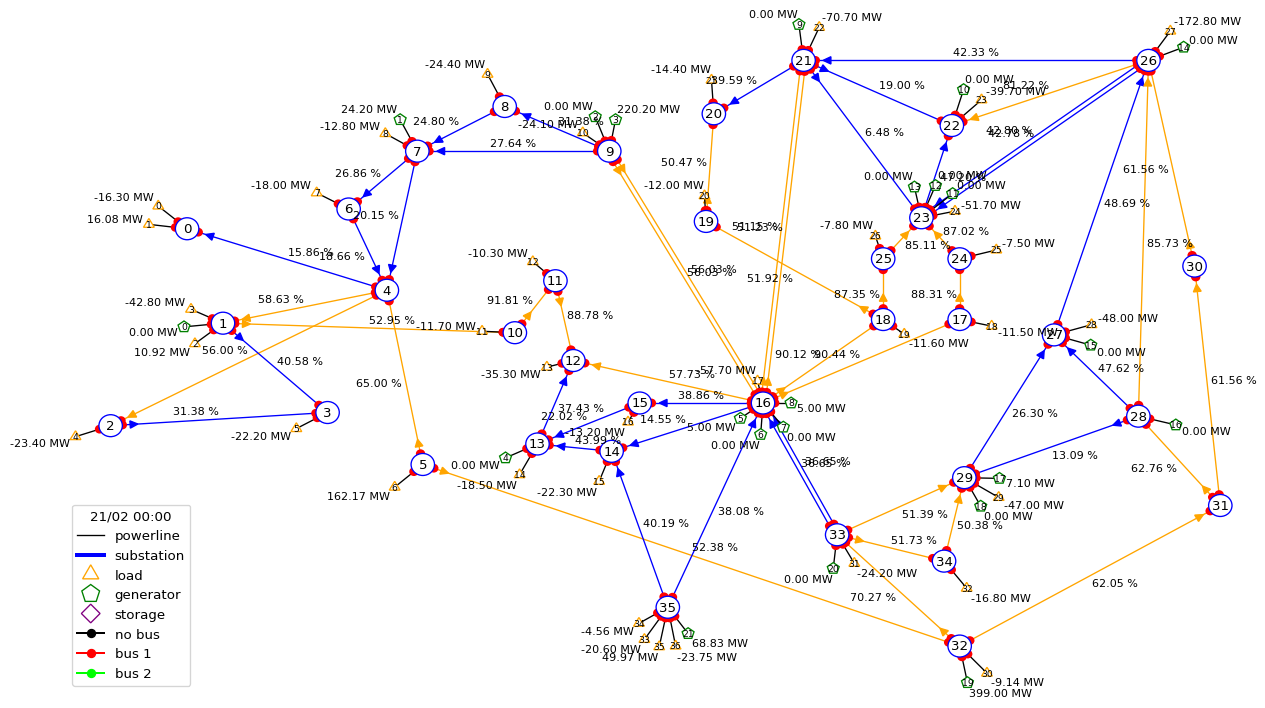

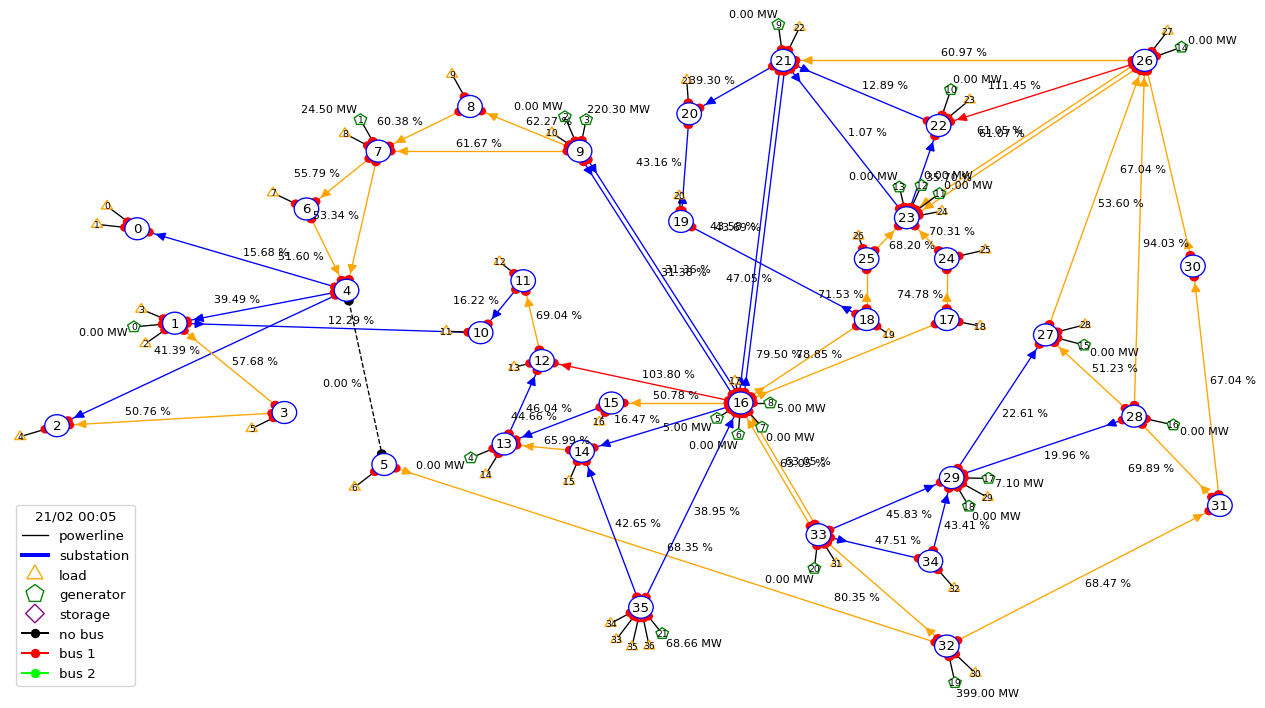

In [15]:
env.set_id(1)
env.seed(1)
obs = env.reset()  # remember we broke everything in our previous demonstration, so we restart properly
_ = plot_helper.plot_obs(obs)
next_obs, reward, done, extra_information = env.step(env.action_space({"set_line_status": 
                                                                       [(contingency_id, -1)]}))
# imagine we are in this state
_ = plot_helper.plot_obs(next_obs, load_info=None)

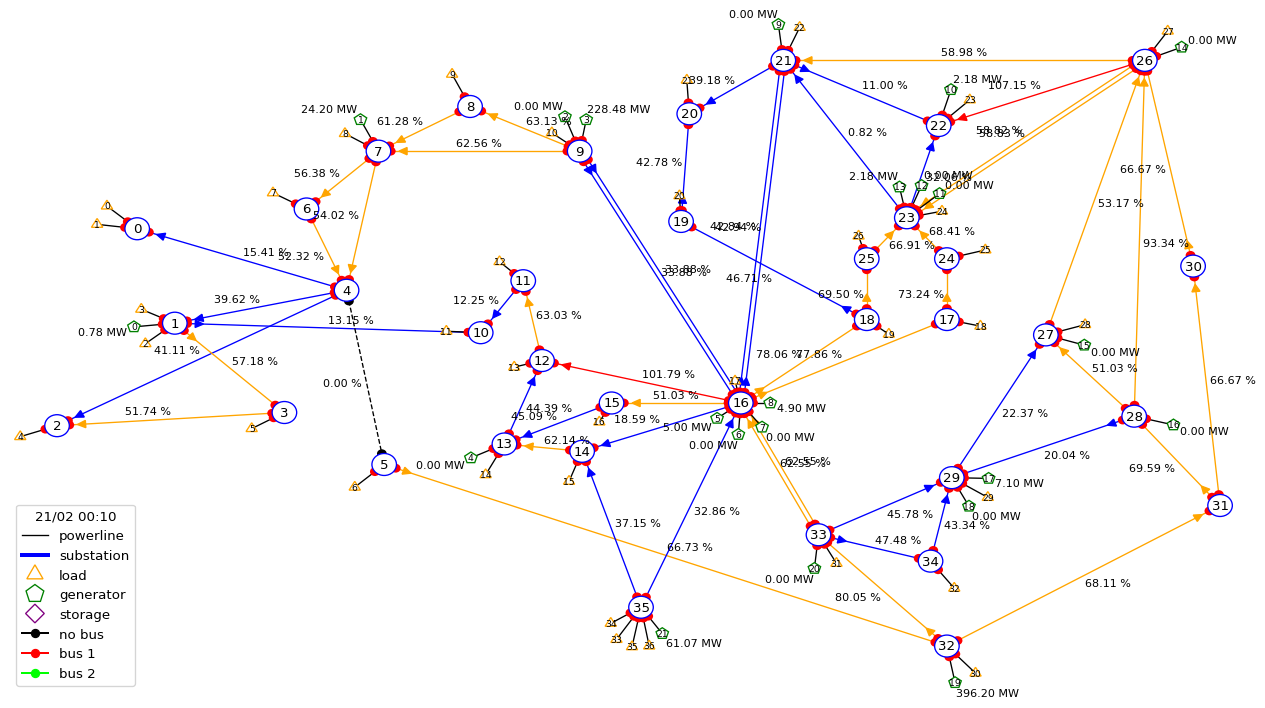

In [16]:
action_redisp = env.action_space({"redispatch": [
    (0, +1.4), (3, +8.8),
    (10, +2.8), (13, +2.8),
    (21, -9.9), (19, -2.8)
]})
next_obs, reward, done, extra_information = env.step(action_redisp)
_ = plot_helper.plot_obs(next_obs, load_info=None)

price_t = np.max(next_obs.gen_cost_per_MW[next_obs.gen_p > 0.]).astype(float)
loss_cost = (np.sum(next_obs.gen_p) - np.sum(next_obs.load_p)) * price_t
resdisp_cost = np.sum(np.abs(next_obs.actual_dispatch)) * price_t
       

A few notes here:

- the maximum possible for each generator were asked in the action
- some generator were dispatchable but were not turned off, though they could have helped
- dispite our effort, no powerlines is "saved"


Let's see if we pursue in this direction

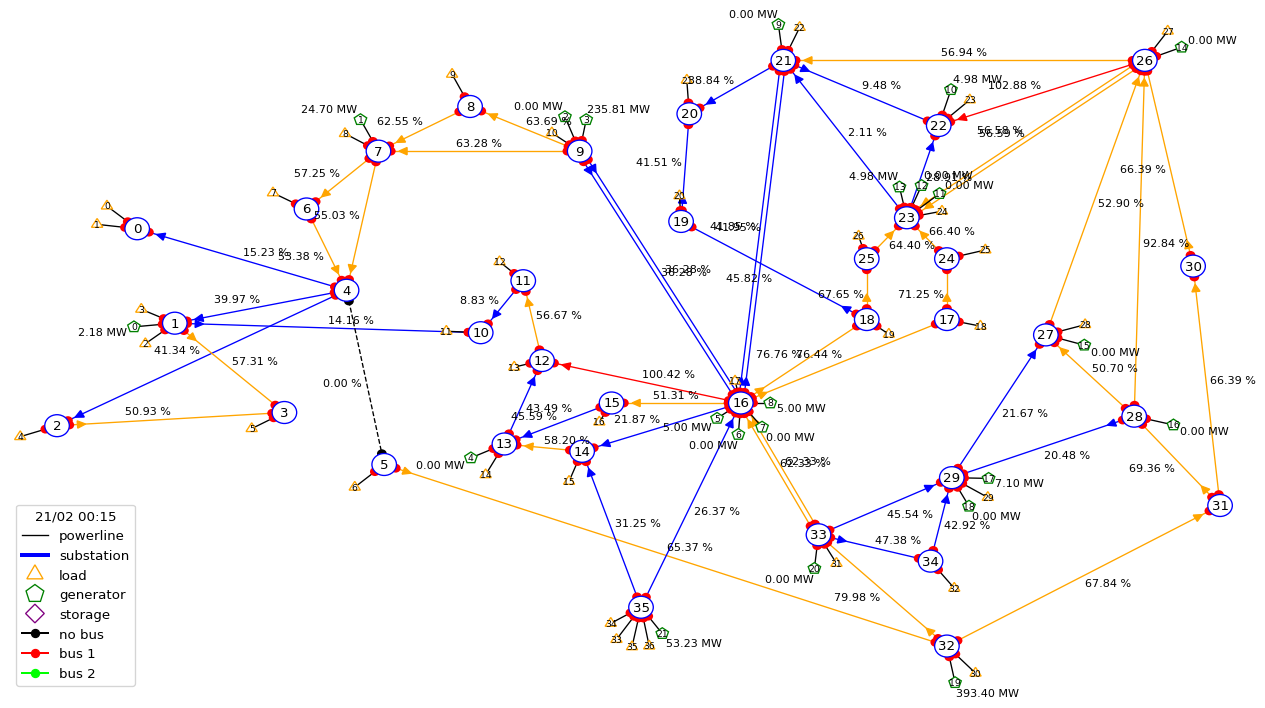

In [17]:
next_obs, reward, done, extra_information = env.step(action_redisp)
_ = plot_helper.plot_obs(next_obs, load_info=None)

price_t = np.max(next_obs.gen_cost_per_MW[next_obs.gen_p > 0.]).astype(float)
loss_cost += (np.sum(next_obs.gen_p) - np.sum(next_obs.load_p)) * price_t
resdisp_cost += np.sum(np.abs(next_obs.actual_dispatch)) * price_t

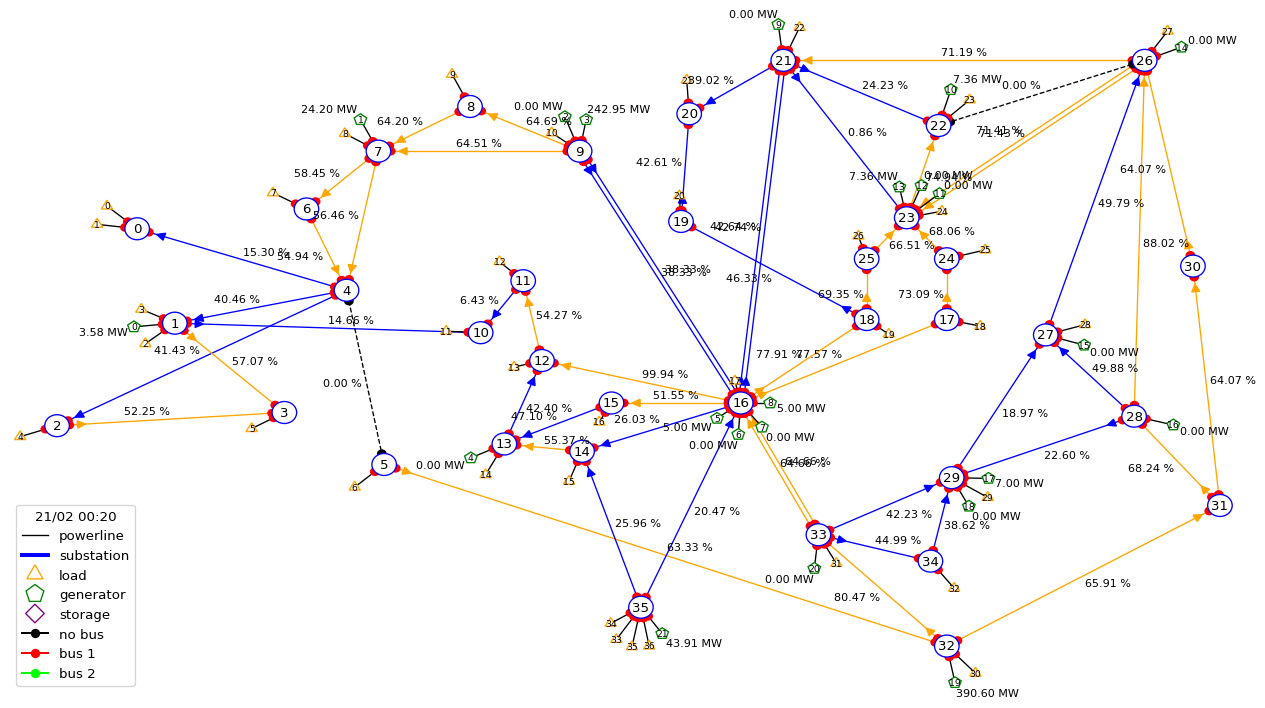

In [18]:
next_obs, reward, done, extra_information = env.step(action_redisp)
_ = plot_helper.plot_obs(next_obs, load_info=None)

price_t = np.max(next_obs.gen_cost_per_MW[next_obs.gen_p > 0.]).astype(float)
loss_cost += (np.sum(next_obs.gen_p) - np.sum(next_obs.load_p)) * price_t
resdisp_cost += np.sum(np.abs(next_obs.actual_dispatch)) * price_t

The cost of performing the redispatching action for the 3 time steps is $7518.
In the mean time the cost due to Joule's effect is $3364, for the whole grid!
If i do the action above i can survive 5 time steps (we stopped the 'game' after 5 time steps)


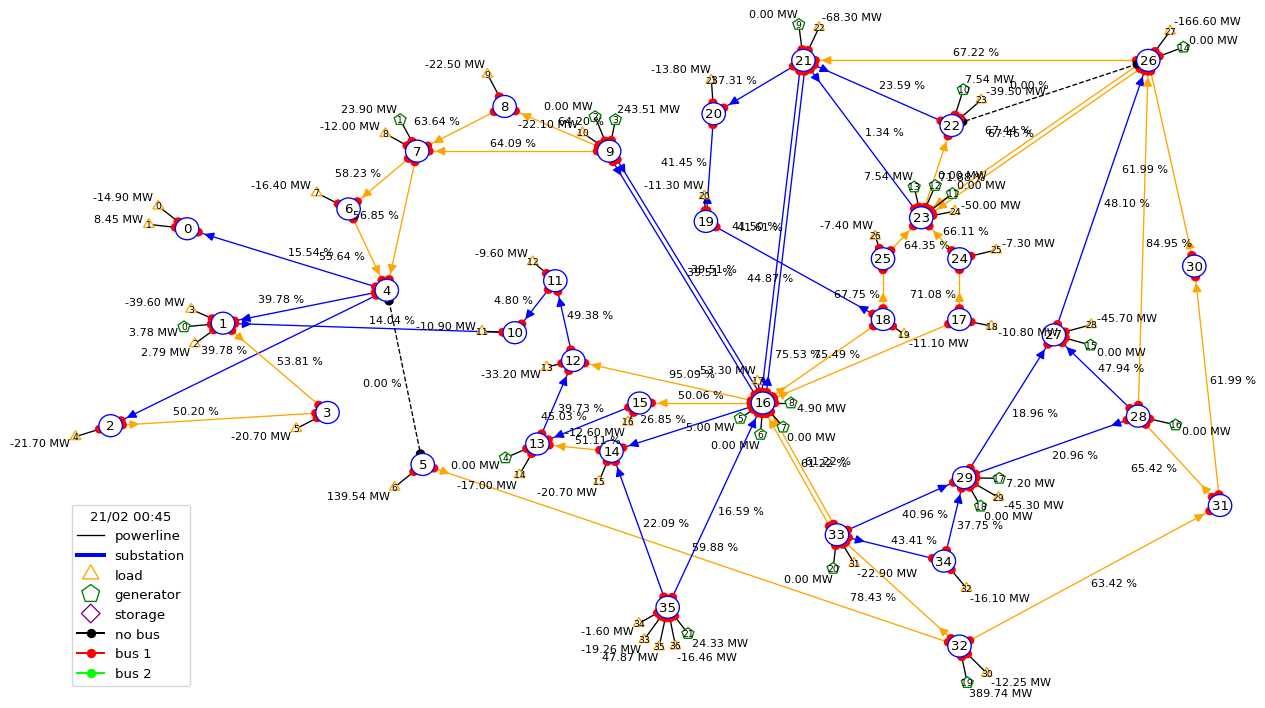

In [19]:
print("The cost of performing the redispatching action for the 3 time steps is ${:.0f}.".format(resdisp_cost))
print("In the mean time the cost due to Joule's effect is ${:.0f}, for the whole grid!".format(loss_cost))

ts_lived_now = 0
while not done:
    next_obs, reward, done, extra_information = env.step(do_nothing)
    ts_lived_now += 1
    if max_iter != -1 and ts_lived_now >= max_iter:
        break
print("If i do the action above i can survive {} time steps (we stopped the 'game' after {} time steps)"
      "".format(ts_lived_now, max_iter))
next_obs.line_status[extra_information["disc_lines"]] = False
_ = plot_helper.plot_obs(next_obs)

So what is the take away here:
- redispatching action are tricky, because generators cannot be modified at will (physical constraint)
- solving entirely the same problem as above was really difficult here, we could not resolve the issue on powerline 22 -> 26
- the cost of this action is rather high, especially compared to the cost (almost 0) of performing a topological action

# Live Demo 2: how to make an agent

The best way to start is to have a look at the l2rpn_baselines packages. It makes the creation and loading / evaluation of agent rather easy. Of course it is rather meant to expose what can be done with grid2op, the "baselines" showed there are not especially well performing.

## 1) Train an agent

In [20]:
# example of training an agent
from l2rpn_baselines.DuelQSimple import train
from l2rpn_baselines.utils import NNParam, TrainingParam
import shutil

train_iter = 60  # again for time constraints. You should expect a real model to be trained on way more data


agent_name = "test_agent"
save_path = "saved_agent_DDDQN_BDA_{}".format(train_iter)
logs_dir="tf_logs_DDDQN"

# because this notebook is executed often, i clean the "save_path"
shutil.rmtree(save_path, ignore_errors=True)

# we then define the neural network we want to make (you may change this at will)
## 1. first we choose what "part" of the observation we want as input, 
## here for example only the generator and load information
## see https://grid2op.readthedocs.io/en/latest/observation.html#main-observation-attributes
## for the detailed about all the observation attributes you want to have
li_attr_obs_X = ["gen_p", "gen_v", "load_p", "load_q"]
# this automatically computes the size of the resulting vector
observation_size = NNParam.get_obs_size(env, li_attr_obs_X) 

## 2. then we define its architecture
sizes = [300, 300, 300]  # 3 hidden layers, of 300 units each, why not...
activs =  ["relu" for _ in sizes]  # all followed by relu activation, because... why not
## 4. you put it all on a dictionnary like that (specific to this baseline)
kwargs_archi = {'observation_size': observation_size,
                'sizes': sizes,
                'activs': activs,
                "list_attr_obs": li_attr_obs_X}

# you can also change the training parameters you are using
# more information at https://l2rpn-baselines.readthedocs.io/en/latest/utils.html#l2rpn_baselines.utils.TrainingParam
tp = TrainingParam()
tp.batch_size = 32  # for example...
tp.update_tensorboard_freq = int(train_iter / 10)
tp.save_model_each = int(train_iter / 3)
tp.min_observation = int(train_iter / 5)

# which actions i keep (on this small environment i CANNOT train an agent to perform the 66k actions)
kwargs_converters = {"all_actions": None,
                     "set_line_status": False,
                     "change_line_status": True,
                     "change_bus_vect": False,
                     "set_topo_vect": False
                     }
    
train(env,
      name=agent_name,
      iterations=train_iter,
      save_path=save_path,
      load_path=None, # put something else if you want to reload an agent instead of creating a new one
      logs_dir=logs_dir,
      kwargs_archi=kwargs_archi,
      training_param=tp,
      kwargs_converters=kwargs_converters,)

 25%|██▌       | 15/60 [00:00<00:04,  9.47it/s]/home/benjamin/Documents/l2rpn-baselines/l2rpn_baselines/utils/DeepQAgent.py:996: RuntimeWarning: invalid value encountered in double_scalars
  curr_inj / total_act_num,
/home/benjamin/Documents/l2rpn-baselines/l2rpn_baselines/utils/DeepQAgent.py:1002: RuntimeWarning: invalid value encountered in double_scalars
  curr_volt / total_act_num,
/home/benjamin/Documents/l2rpn-baselines/l2rpn_baselines/utils/DeepQAgent.py:1008: RuntimeWarning: invalid value encountered in double_scalars
  curr_topo / total_act_num,
/home/benjamin/Documents/l2rpn-baselines/l2rpn_baselines/utils/DeepQAgent.py:1014: RuntimeWarning: invalid value encountered in double_scalars
  curr_line / total_act_num,
/home/benjamin/Documents/l2rpn-baselines/l2rpn_baselines/utils/DeepQAgent.py:1020: RuntimeWarning: invalid value encountered in double_scalars
  curr_redisp / total_act_num,
/home/benjamin/Documents/l2rpn-baselines/l2rpn_baselines/utils/DeepQAgent.py:1026: RuntimeWar

Logs are saved in the "tf_logs_DDDQN" log repository. To watch what happens during training, you can type the command (from a bash command line for example):
```
tensorboard --logdir='tf_logs_DDDQN'
```
You can even do it while it's training. Tensorboard allows you to monitor, during training, different quantities, for example the loss of your neural network or even the last number of steps the agent performed before getting a game over etc.

At first glimpse here is what it could look like (only the first graph out of :


Monitoring of the training |  Representation as a graph of the neural network
:-------------------------:|:-------------------------:
![](./img/tensorboard_example.png) |  ![](./img/tensorboard_graph.png)

## 2) Evaluate the agent

In [21]:
from l2rpn_baselines.DuelQSimple import evaluate
path_save_results = "{}_results".format(save_path)
shutil.rmtree(path_save_results, ignore_errors=True)
evaluated_agent, res_runner = evaluate(env,
                                       name=agent_name,
                                       load_path=save_path,
                                       logs_path=path_save_results,
                                       nb_episode=2,
                                       nb_process=1,
                                       max_steps=max_iter,
                                       verbose=True,
                                       save_gif=False)

episode:   0%|          | 0/2 [00:00<?, ?it/s]

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
observation (InputLayer)        [(None, 118)]        0                                            
__________________________________________________________________________________________________
layer_0 (Dense)                 (None, 300)          35700       observation[0][0]                
__________________________________________________________________________________________________
activation_6 (Activation)       (None, 300)          0           layer_0[0][0]                    
__________________________________________________________________________________________________
layer_1 (Dense)                 (None, 300)          90300       activation_6[0][0]               
_______________________________________________________________________________________


episode:  50%|█████     | 1/2 [00:00<00:00,  1.65it/s]

INFO: "Creating path "/home/benjamin/Documents/grid2op_dev/getting_started/saved_agent_DDDQN_BDA_60_results/Scenario_august_dummy" to save the episode Scenario_august_dummy"
INFO: "Env: 0.10s
	 - apply act 0.03s
	 - run pf: 0.07s
	 - env update + observation: 0.00s
Agent: 0.01s
Total time: 0.11s
Cumulative reward: 2126.304688"



episode: 100%|██████████| 2/2 [00:00<00:00,  2.25it/s]

INFO: "Creating path "/home/benjamin/Documents/grid2op_dev/getting_started/saved_agent_DDDQN_BDA_60_results/Scenario_february_dummy" to save the episode Scenario_february_dummy"
INFO: "Env: 0.10s
	 - apply act 0.03s
	 - run pf: 0.06s
	 - env update + observation: 0.00s
Agent: 0.01s
Total time: 0.11s
Cumulative reward: 4161.120117"
Evaluation summary:
chronics at: Scenario_august_dummy	total score: 2126.304688	time steps: 5/5
chronics at: Scenario_february_dummy	total score: 4161.120117	time steps: 5/5
The agent played 3 different action
Action with ID 10 was played 5 times
This action will:
	 - NOT change anything to the injections
	 - NOT perform any redispatching action
	 - NOT modify any storage capacity
	 - NOT perform any curtailment
	 - NOT force any line status
	 - Switch status of 1 powerlines ([9])
	 - NOT switch anything in the topology
	 - NOT force any particular bus configuration
-----------
Action with ID 139 was played 4 times
This action will:
	 - NOT change anything to

In [22]:
for _, _, score, nb_ts, total_ts in res_runner:
    print("The final score is {:.0f} and {}/{} time steps were successfully performed".format(score, nb_ts, total_ts))

The final score is 2126 and 5/5 time steps were successfully performed
The final score is 4161 and 5/5 time steps were successfully performed


Of course you can also have a look at your agent log using the dedicated GUI that we developed for this competition.

This is called "grid2viz" and will output something like this (**NB** this was logs generated for a smaller environment, this is NOT the log of this agent)


## 3) And now you simply need to submit your agent on the codalab platform :-)

This is beyond the scope of this tutorial. The starting kit of these competitions, that you can download once registered are here to guide you